# 2) Base line CNN tuning

**Warning** : This notebook was created with [Colab](https://colab.research.google.com). Measured times were performed in GPU mode. This will use a large part of RAM for dataset proccessing, so please reset the runtime and run all cells. 


In [0]:
!rm dogImages.zip
!rm -rf dogImages
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip -qq dogImages.zip
!rm *.py
!wget https://raw.githubusercontent.com/mrugeles/dog_breeds/master/data_utils.py
!wget https://raw.githubusercontent.com/mrugeles/dog_breeds/master/model_utils.py

rm: cannot remove 'dogImages.zip': No such file or directory
--2019-05-09 17:16:17--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 54.231.235.45
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|54.231.235.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  20.3MB/s    in 54s     

2019-05-09 17:17:12 (19.9 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

rm: cannot remove '*.py': No such file or directory
--2019-05-09 17:17:30--  https://raw.githubusercontent.com/mrugeles/dog_breeds/master/data_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
H

In [0]:
import data_utils
import model_utils
import time

BATCH_SIZE = 16
TRAIN_PATH = './dogImages/train'
VALID_PATH = './dogImages/valid'
TEST_PATH = './dogImages/test'

WEIGHTS_FILE = 'weights.base.balanced.hdf5'
MODEL_FILE = 'weights.base.balanced.json'


Using TensorFlow backend.


In [0]:
train_files, train_targets, valid_files, valid_targets, test_files, test_targets, dog_names = data_utils.load_datasets(TRAIN_PATH, VALID_PATH, TEST_PATH, False)


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


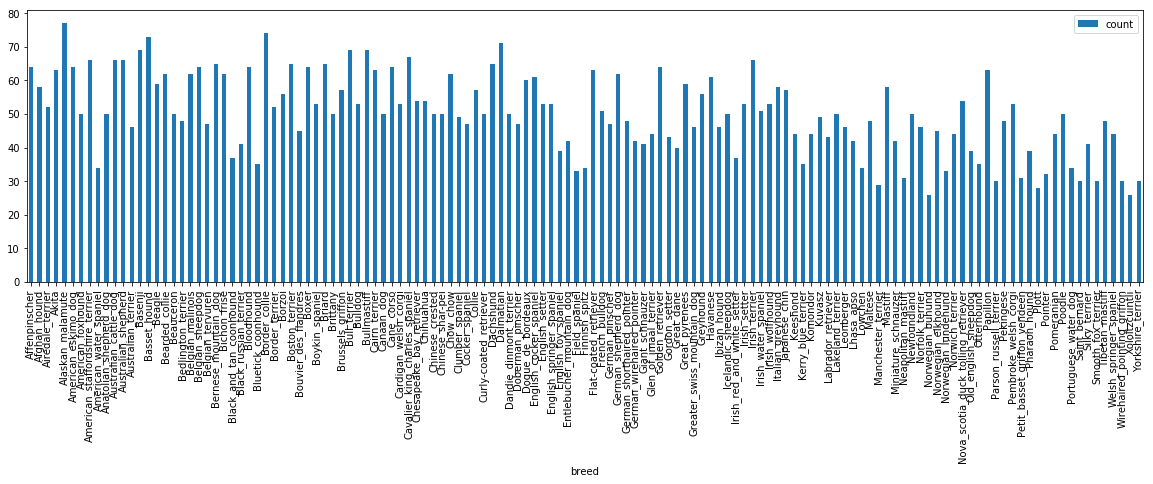

In [0]:
data_utils.show_target_distribution(TRAIN_PATH)

In [0]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = data_utils.paths_to_tensor(train_files).astype('float32')/255
valid_tensors = data_utils.paths_to_tensor(valid_files).astype('float32')/255
test_tensors = data_utils.paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:06<00:00, 125.08it/s]


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxP

### Balancing classes

In [0]:
class_weights = data_utils.get_class_weights(train_targets)

Instructions for updating:
Use tf.cast instead.


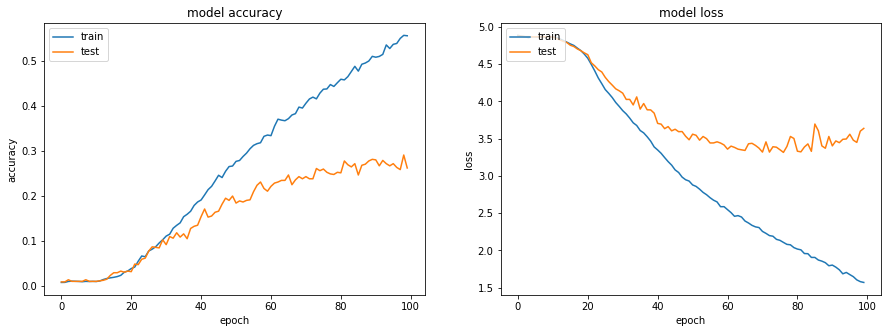

Test accuracy: 23.3254%
Training time: 25.4667% minutes


In [0]:
start_time = time.time()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 100

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath=WEIGHTS_FILE, 
                               verbose=0, save_best_only=True)

history = model.fit(train_tensors, 
                    train_targets, 
                    class_weight = class_weights,
                    validation_data=(valid_tensors, valid_targets),
                    epochs=epochs, 
                    batch_size=32, 
                    callbacks=[checkpointer], 
                    verbose=0)

model_utils.plot_history(history, 'sparse_categorical_accuracy', 'val_sparse_categorical_accuracy')

accuracy = model_utils.eval_model(model, WEIGHTS_FILE, test_tensors, test_targets, False)
print('Test accuracy: %.4f%%' % accuracy)

end_time = time.time() - start_time
print('Training time: %.4f%% minutes' % (end_time / 60))

### Data Augmentation with balanced classes

In [0]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 16

train_datagen = ImageDataGenerator(
          rescale=1./255,
          rotation_range=90,
          width_shift_range=0.1,
          height_shift_range=0.1,
          zoom_range=0.2,
          horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './dogImages/train', 
        target_size=(224, 224), 
        batch_size=batch_size,
        class_mode='sparse')  

validation_generator = test_datagen.flow_from_directory(
        './dogImages/valid',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='sparse')

Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.


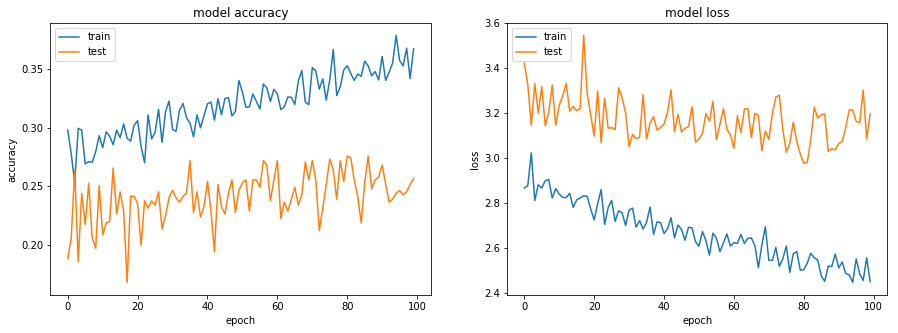

Test accuracy: 29.1866%
Training time: 66.6926% minutes


In [0]:
start_time = time.time()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 100

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath=WEIGHTS_FILE, 
                               verbose=0, save_best_only=True)

history = model.fit_generator(
        train_generator,
        class_weight = class_weights,
        steps_per_epoch=2000 // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=800 // batch_size,
        callbacks=[checkpointer], verbose=0)

model_utils.plot_history(history, 'sparse_categorical_accuracy', 'val_sparse_categorical_accuracy')

accuracy = model_utils.eval_model(model, WEIGHTS_FILE, test_tensors, test_targets, False)
print('Test accuracy: %.4f%%' % accuracy)

end_time = time.time() - start_time
print('Training time: %.4f%% minutes' % (end_time / 60))

### Data Augmentation with unbalanced classes

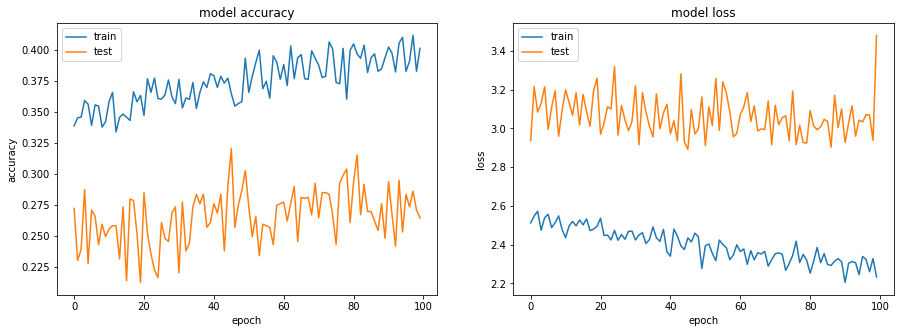

Test accuracy: 30.1435%
Training time: 66.2426% minutes


In [0]:
start_time = time.time()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 100

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath=WEIGHTS_FILE, 
                               verbose=0, save_best_only=True)

history = model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=800 // batch_size,
        callbacks=[checkpointer], verbose=0)

model_utils.plot_history(history, 'sparse_categorical_accuracy', 'val_sparse_categorical_accuracy')

accuracy = model_utils.eval_model(model, WEIGHTS_FILE, test_tensors, test_targets, False)
print('Test accuracy: %.4f%%' % accuracy)

end_time = time.time() - start_time
print('Training time: %.4f%% minutes' % (end_time / 60))

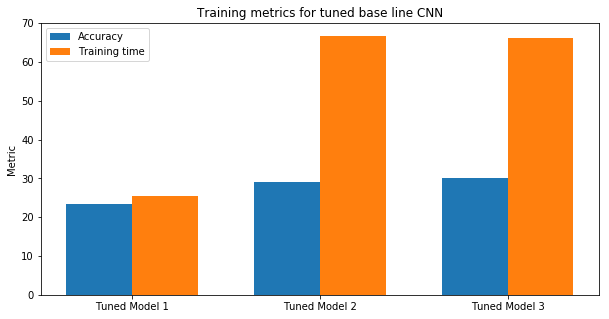

In [1]:
import matplotlib.pyplot as plt
import numpy as np

N = 3
accuracy = (23.32, 29.18, 30.14)
training_time = (25.46, 66.69, 66.24)

ind = np.arange(N) 
width = 0.35   
plt.subplots(1, 1, figsize=(10, 5))
plt.bar(ind, accuracy, width, label='Accuracy')
plt.bar(ind + width, training_time, width, label='Training time')

plt.ylabel('Metric')
plt.title('Training metrics for tuned base line CNN')

plt.xticks(ind + width / 2, ('Tuned Model 1', 'Tuned Model 2', 'Tuned Model 3'))
plt.legend(loc='best')
plt.show()